# Causal Modelling with DoWhy and EconML

# Imports

In [22]:
import numpy as np
import pandas as pd

from IPython.display import Image, display
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import econml
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

from dowhy import CausalModel

import shap

# Read data

In [2]:
df = pd.read_csv('../data/causal_df.csv')

In [3]:
df.head()

,Unnamed: 0,date,day_of_week,weather_region_cd,maximum_feels_like_temperature,rainfall,sunshine_td,avg_ice_cream_price,ice_cream_sold,cpih,month
0,0,2022-03-27,0.0,1.0,15.4,0.2,12.1,2.704702,1498.0,6.2,3.0
1,1,2022-03-27,0.0,10.0,12.7,0.0,10.6,2.704702,2285.0,6.2,3.0
2,2,2022-03-27,0.0,11.0,15.1,0.0,10.2,2.704702,5509.0,6.2,3.0
3,3,2022-03-27,0.0,12.0,10.7,0.0,5.3,2.704702,7776.0,6.2,3.0
4,4,2022-03-27,0.0,13.0,13.1,0.0,8.6,2.704702,4903.0,6.2,3.0


# Creating Causal Graph

In [4]:
# Define estimator inputs
treatment = "maximum_feels_like_temperature"  # outcome of interest
outcome = "ice_cream_sold"  # intervention, or treatment
covariates = ["avg_ice_cream_price", "cpih", "rainfall", "sunshine_td"]  # confounders
features = ["weather_region_cd", "day_of_week", "month"]  # confounders

In [52]:
X = df[covariates]
Y = df[outcome]
T = df[treatment]
W = df[features]

In [36]:
Y_train, Y_test, T_train, T_test, X_train, X_test, W_train, W_test = train_test_split(Y, T, X, W, test_size=.2)

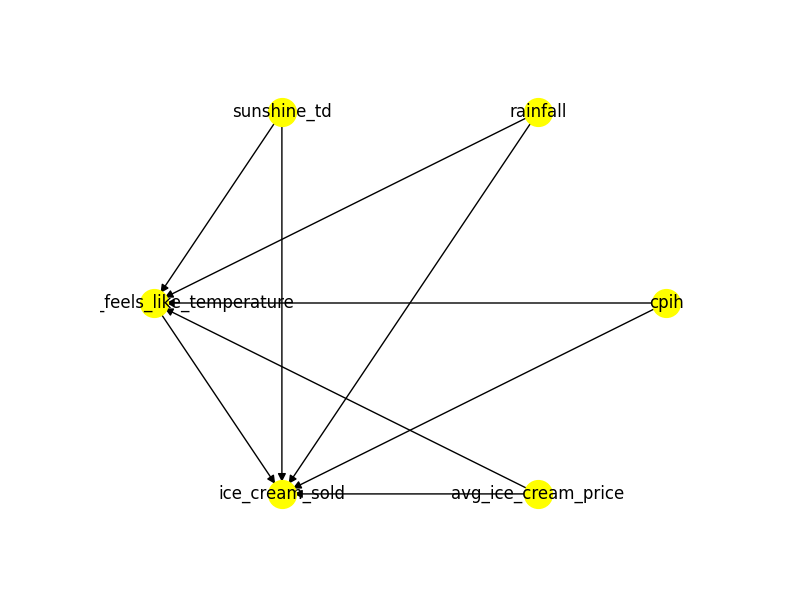

In [60]:
model = CausalModel(
    data=df,
    treatment=treatment, 
    outcome=outcome, 
    common_causes=covariates, 
    instruments=None, 
    effect_modifiers=None)

display(Image(filename="causal_model.png"))

# Estimate Causal Effects

In [56]:
est = CausalForestDML(
                        model_y=RandomForestRegressor(criterion='absolute_error')
                      , model_t=RandomForestRegressor(min_samples_leaf=10, criterion='absolute_error')
                      , discrete_treatment=False
                  )

est.fit(Y, T, X=X, W=W, cache_values=True)

In [61]:
# estimate the CATE with the test set 
est.const_marginal_ate(X_test)

 99%|===================| 6004/6035 [00:42<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


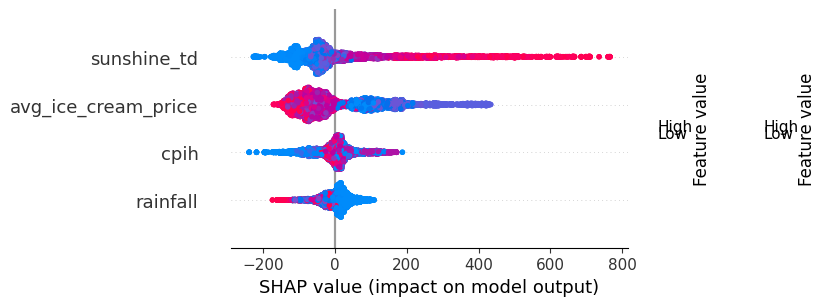

In [11]:
%matplotlib inline

shap_values = est.shap_values(X)
shap.plots.beeswarm(shap_values['ice_cream_sold']['maximum_feels_like_temperature'])

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


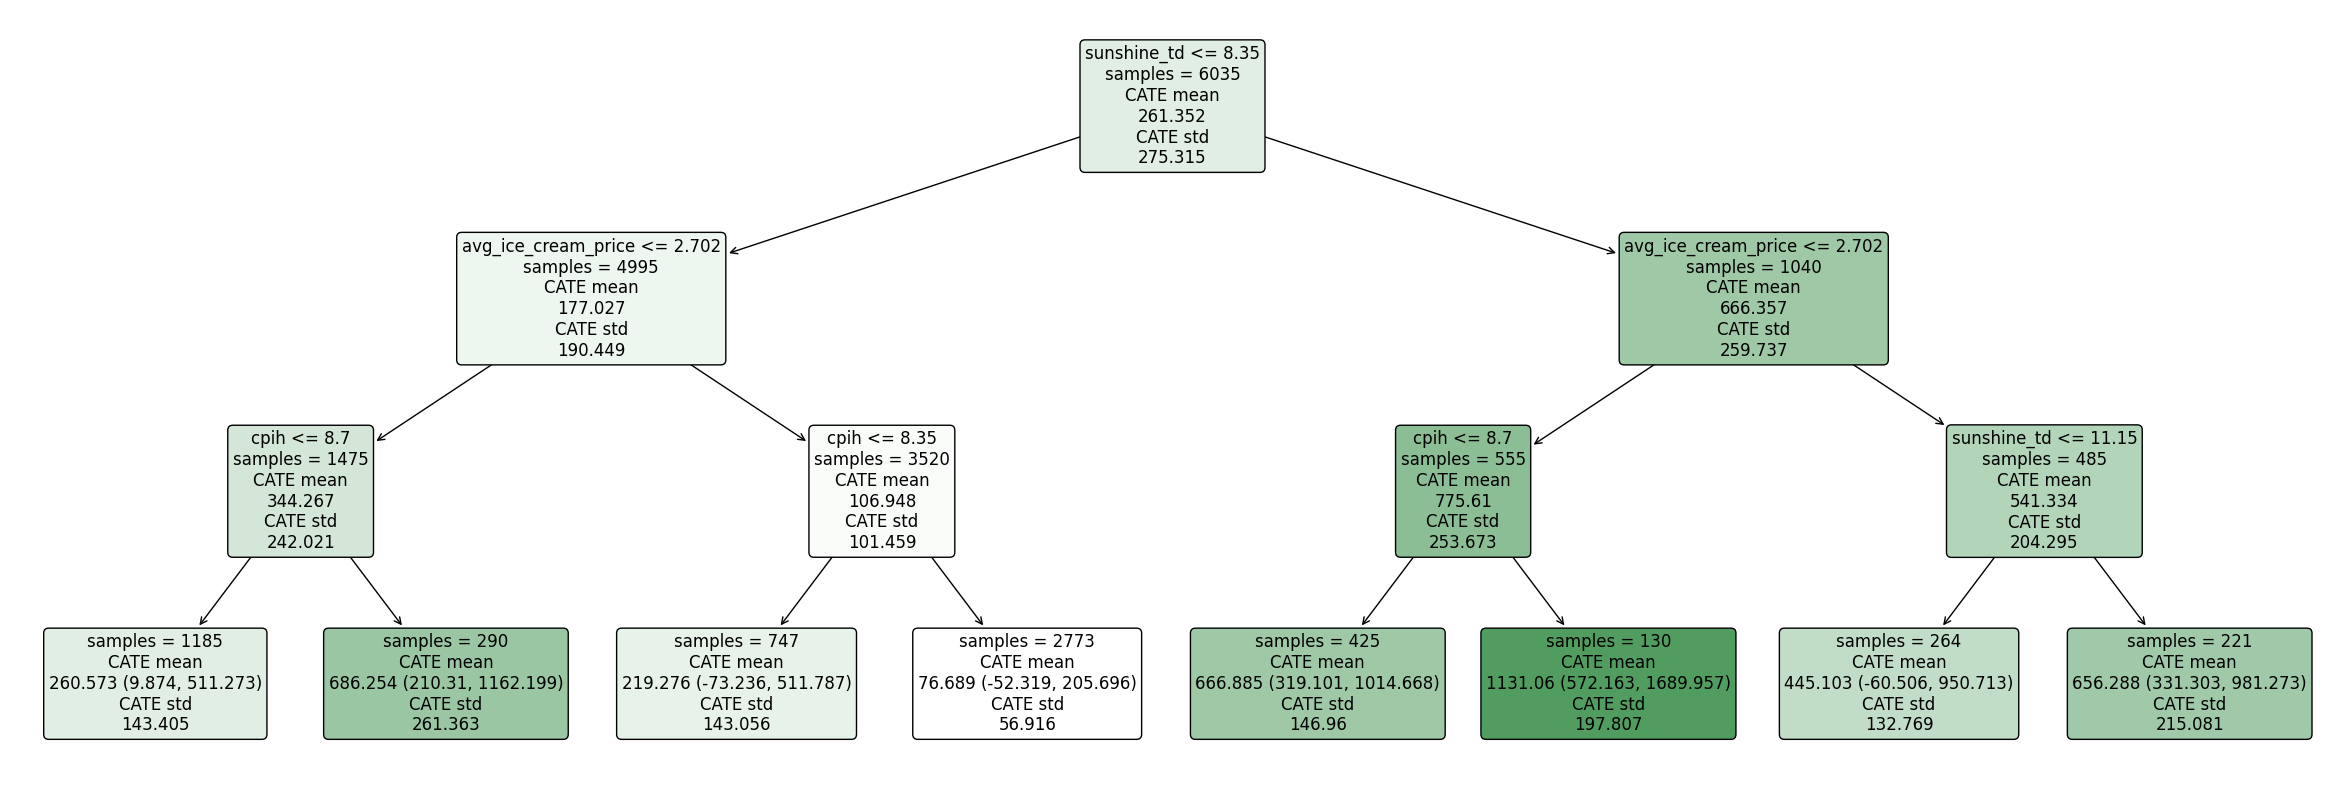

In [21]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3).interpret(est, X)

plt.figure(figsize=(30,10))
intrp.plot(feature_names=X.columns, fontsize=12)

# Refutes!